In [1]:
from PIL import Image
import os
import numpy as np
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import pandas as pd
# import tensorflow as tf
# import argparse
import random


In [2]:
#model hyper parameters:
image_size = 150 
batch_size =100 
learning_rate = 0.001 
image_count_thr = 20
opt ='Adam'
seed=42

In [3]:
modell = "MobileViT_S" 
visit = "0829" 
TT = 'T4'
cv = "cv1" 
cv_rate = 0.75

In [4]:
os.chdir("/home/yebi/ComputerVision_PLF/Pig_BW/Pig_BW_DL_beta/DL/")
df1 = pd.read_csv("./labelled_depth_0718.csv", dtype={'Visit': str})
df2 = pd.read_csv("./labelled_depth_0801.csv", dtype={'Visit': str})
df3 = pd.read_csv("./labelled_depth_0815.csv", dtype={'Visit': str})
df4 = pd.read_csv("./labelled_depth_0829.csv", dtype={'Visit': str})
df5 = pd.read_csv("./labelled_depth_0912.csv", dtype={'Visit': str})
df6 = pd.read_csv("./labelled_depth_0927.csv", dtype={'Visit': str})


# # labelled_depth = pd.concat([df1, df2, df3], axis=0)
if cv == 'cv1':
    print(visit)
    if visit == "0718":
        labelled_depth = df1
    elif visit == "0801":
        labelled_depth = df2
    elif visit == "0815":
        labelled_depth = df3
    elif visit == "0829":
        labelled_depth = df4
    elif visit == "0912":
        labelled_depth = df5
    elif visit == "0927":
        labelled_depth = df6

if cv == "cv2" or cv == 'cv2_0':
    if visit == "0801":
        labelled_depth = pd.concat([df1, df2], axis=0)
    elif visit == "0815":
        labelled_depth = pd.concat([df1, df2, df3], axis=0)
    elif visit == "0829":
        labelled_depth = pd.concat([df1, df2, df3, df4], axis=0)
    elif visit == "0912":
        labelled_depth = pd.concat([df1, df2, df3, df4, df5], axis=0)
    elif visit == "0927":
        labelled_depth = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)

print("Total images are ", labelled_depth.shape[0])

0829
Total images are  54580


In [5]:
######################################################################
# Remove outliers in ground truth body weights.
# weight_percentile = 3
# weight_threshold = labelled_depth["Weights"].quantile(weight_percentile / 100)
# labelled_depth = labelled_depth[labelled_depth["Weights"] >= weight_threshold]
# print(f"Remove weight outliers by {weight_percentile}% quantile")

# lower_percentile = 2
# upper_percentile = 100

# # Calculate the lower and upper weight thresholds
# lower_weight_threshold = labelled_depth["Weights"].quantile(lower_percentile / 100)
# upper_weight_threshold = labelled_depth["Weights"].quantile(upper_percentile / 100)

# # Filter the dataframe to remove outliers
# labelled_depth = labelled_depth[
#     (labelled_depth["Weights"] >= lower_weight_threshold) &
#     (labelled_depth["Weights"] <= upper_weight_threshold)
# ]


In [6]:
######################################################################
# Count the occurrences of each category
category_counts = labelled_depth['Bag_ID'].value_counts()
# Select rows based on the frequency condition
selected_rows = pd.DataFrame()
for category, count in category_counts.items():
    category_data = labelled_depth[labelled_depth['Bag_ID'] == category]
    if count <= image_count_thr:
        selected_rows = pd.concat([selected_rows, category_data])
    else:
        interval = count // image_count_thr
        selected_indices = np.arange(0, count, interval)[:image_count_thr]
        selected_rows = pd.concat([selected_rows, category_data.iloc[selected_indices]])
labelled_depth = selected_rows
print("Total images are ", labelled_depth.shape[0])

Total images are  11347


In [7]:
if cv == "cv1":
    import random
    random.seed(seed)
    pig_n = np.unique(labelled_depth['Bag_ID']).shape[0]
    train_bag_id = random.sample(list(np.unique(labelled_depth["Bag_ID"])), int(pig_n*0.8))
    train_df = labelled_depth[labelled_depth["Bag_ID"].isin(train_bag_id)]
    test_df = labelled_depth[-labelled_depth["Bag_ID"].isin(train_bag_id)]

elif cv == 'cv2':
    cv_name = "CrossValidation" + str(cv_rate)
    train_df = labelled_depth[labelled_depth[cv_name] == "train"]
    test_df = labelled_depth[(labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] == visit)]

elif cv == 'cv2_0':
    cv_name = "CrossValidation" + str(cv_rate)
    train_df = labelled_depth[
        (labelled_depth[cv_name] == "train") | 
        ((labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] != visit))
        ]
    test_df = labelled_depth[(labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] == visit)]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40., 149., 200.,
        180., 373., 405., 213., 220., 240., 195.,  40.,   0.]),
 array([ 38.,  43.,  48.,  53.,  58.,  63.,  68.,  73.,  78.,  83.,  88.,
         93.,  98., 103., 108., 113., 118., 123., 128., 133., 138.]),
 <BarContainer object of 20 artists>)

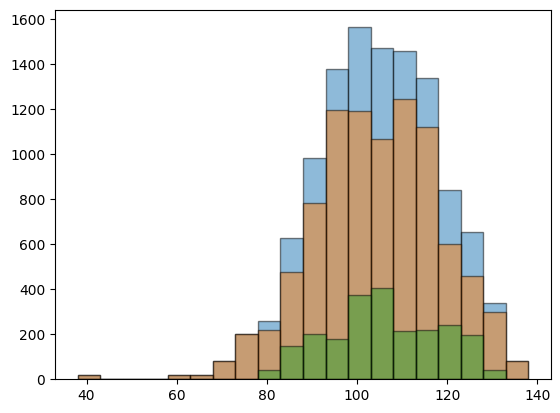

In [8]:
minbw, maxbw = np.min(labelled_depth["Weights"]), np.max(labelled_depth["Weights"])
bin_edges = np.arange(int(minbw), int(maxbw), 5)  # bins from 40 to 110 with a distance of 10

# Plot the histogram
plt.hist(labelled_depth['Weights'], bins=bin_edges, edgecolor='black', alpha=0.5)
plt.hist(train_df['Weights'], bins=bin_edges, edgecolor='black', alpha=0.5)
plt.hist(test_df["Weights"], bins=bin_edges, edgecolor='black', alpha=0.5)

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import random
import pandas as pd
import tensorflow as tf
import argparse
import keras_cv_attention_models
import glob
from keras.models import Model

In [37]:

def read_images(labelled_depth, image_size):
    images = []
    img_paths = []
    for filename in labelled_depth["FilePath"]:
        if filename.endswith('.png'):  
            if os.path.exists(filename):
                img_path = filename
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)  
                img = tf.image.resize_with_crop_or_pad(img, target_height=int(img.shape[1]), target_width=int(img.shape[1]))
                img = tf.image.resize(img, [image_size, image_size]) #Resize images
                images.append(img)
                img_paths.append(img_path)

    processed_images = tf.stack(images)
    processed_images = tf.cast(processed_images, tf.float32)
    processed_images /= 255.0
    print("DDDDDDDDDDDDDDDDDDDDDDDD")
    return processed_images, img_paths

print("Now is reading testing sets")
x_test, test_img_path = read_images(labelled_depth=test_df, image_size = image_size)
print("x_test shape is: ", x_test.shape, len(test_img_path))
y_test = test_df["Weights"].values
y_test = y_test.astype(np.float32)
print("y_test shape is: ", y_test.shape)


Now is reading testing sets
DDDDDDDDDDDDDDDDDDDDDDDD
x_test shape is:  (2334, 150, 150, 3) 2334
y_test shape is:  (2334,)


In [28]:
print(len(set(train_df["Bag_ID"])))
len(set(test_df["Bag_ID"]))

462


116

In [29]:

def keras_cv_attention_model(modell):           
    if modell == "MobileViT_XXS":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_XXS(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileViT_S":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_S(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileViT_V2_050":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_050(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileViT_V2_100":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_100(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileViT_V2_150":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_150(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileViT_V2_200":
        base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_200(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileNetV3Small050":
        base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Small050(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileNetV3Large075":
        base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Large075(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    elif modell == "MobileNetV3Large100":
        base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Large100(pretrained="imagenet", num_classes=0, input_shape=(image_size, image_size, 3))
    else:
        raise ValueError(f"Model {modell} not recognized in keras_cv_attention_model function")

    return base_model


############################
def keras_model(modell):
    if modell == "ResNet50":
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif modell == "MobileNet050":
        base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=0.5)
    elif modell == "MobileNet100":
        base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=1.0) 
    elif modell == "MobileNet075":
        base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=0.75)   
    else:
        raise ValueError(f"Model {modell} not recognized in keras_model function")
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = trainable

    return base_model


############################    
def load_model(model):
    try:
        return keras_cv_attention_model(model)
    except ValueError:
        return keras_model(model)
############################



if TT == 'T4':
    base_model = load_model(model=modell)
    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='linear', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
else:
    base_model = load_model(model = modell)    
    # Add a custom regression layer on top of the base model
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))  # Add dropout layer with 50% dropout rate
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.001)))  # The output layer for regression with L2 regularization

if opt == "Adam":
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, epsilon=1e-05)

model.compile(optimizer=optimizer, 
            loss=keras.losses.MeanSquaredError(), 
            metrics=[keras.losses.MeanSquaredError()])


>>>> Load pretrained from: /home/yebi/.keras/models/mobilevit_s_imagenet.h5


In [38]:

seed = 42
# Train the model using the generators
    # Set random seed for TensorFlow
tf.random.set_seed(seed)
# Set random seed for numpy
np.random.seed(seed)
# Set random seed for Python's built-in random module
random.seed(seed)

if TT == "T1":
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T1/checkpoint_MobileViT_XXS_visit_0718_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'

if TT == 'T2':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T2/checkpoint_MobileViT_S_visit_0801_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'

if TT == 'T3':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T3/checkpoint_MobileViT_S_visit_0815_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'

if TT == 'T4':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T4/checkpoint_MobileViT_S_cv1_0.8_visit_0829_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20.h5'

if TT == 'T5':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T5/checkpoint_MobileViT_S_cv1_0.8_visit_0912_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'

if TT == 'T6':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T6/checkpoint_MobileViT_V2_200_visit_0927_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_weightdecay_0.0001'

model.load_weights(checkpoint_filepath)

predicted_weights = np.squeeze(model.predict(x_test))
true_weights = y_test
prediction = pd.DataFrame({
    'predicted_Weights': predicted_weights,
    'true_Weights': true_weights
})



73/73 [==============================] - 2s 25ms/step


In [31]:

# Save the dataframe as a CSV file
# print(TT)
# prediction.to_csv('/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/'+ TT +'/weights_comparison.csv', index=False)
# print("weights_comparison.csv saved")

In [39]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

    
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(true_weights, predicted_weights)**0.5
r2 = r2_score(true_weights,predicted_weights)
MAPE = mape(true_weights, predicted_weights)
MAE = mean_absolute_error(true_weights,predicted_weights)

import sys

# Save the current standard output

print('--------------------------')
print("Model using: ", modell)
print("Seed is setting as:", seed)
print("image_size:", image_size)
print("visit:", visit)
print("cv:", cv)
print("batch_size:", batch_size)
print("learning_rate:", learning_rate)
print("image_count_thr:", image_count_thr)
if opt == "Adam":
    print(f"Optimizer: {opt}")
print("Total images are ", labelled_depth.shape[0])
print('--------------------------')
print('METRICS ON ENTIRE DATASET:')
print('--------------------------')
print("Test RMSE:\t{:.5f}".format(rmse))
print("Test MAE:\t{:.5f}".format(MAE))
print("Test R^2 Score:\t{:.5f}".format(r2))
print("Test MAPE:\t{:.5f}%".format(MAPE))
# print('--------------------------')
# print("Infer RMSE:\t{:.5f}".format(rmse_infer))
# print("Infer R^2 Score:\t{:.5f}".format(r2_infer))
# print("Infert MAPE:\t{:.5f}%".format(MAPE_infer))
print('--------------------------')


--------------------------
Model using:  MobileViT_S
Seed is setting as: 42
image_size: 150
visit: 0815
cv: cv1
batch_size: 100
learning_rate: 0.001
image_count_thr: 20
Optimizer: Adam
Total images are  11568
--------------------------
METRICS ON ENTIRE DATASET:
--------------------------
Test RMSE:	3.17965
Test MAE:	2.20466
Test R^2 Score:	0.93415
Test MAPE:	2.43893%
--------------------------


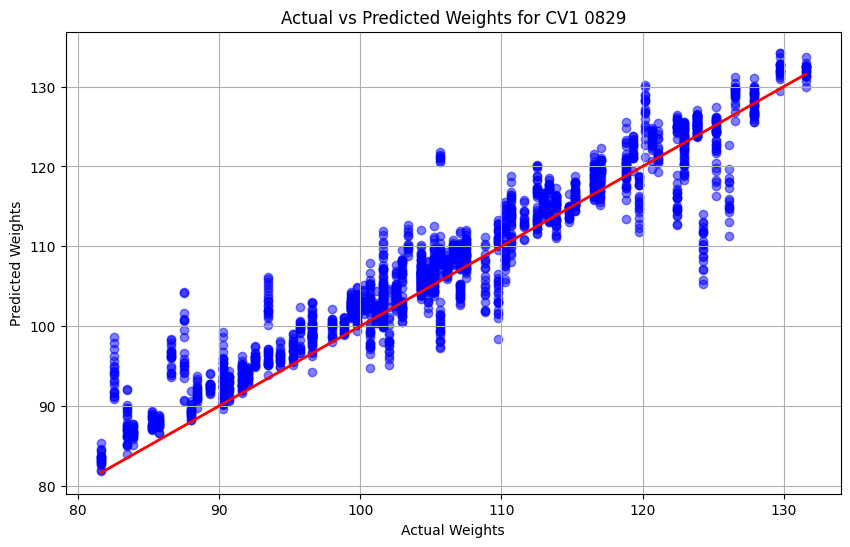

In [308]:
import matplotlib.pyplot as plt

# Assuming y_test and predicted_weights are your actual and predicted weights respectively
# Replace y_test and predicted_weights with your actual data variables

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_weights, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Line of perfect prediction

plt.xlabel('Actual Weights')
plt.ylabel('Predicted Weights')
plt.title('Actual vs Predicted Weights for CV1 '+visit)
plt.grid(True)
plt.show()

In [309]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def mape(true, pred):
    return np.mean(np.abs((true - pred) / true)) * 100

true_weights = y_test


# Generate ranges automatically with a difference of 5 units
min_weight = np.floor(np.min(labelled_depth["Weights"]) / 10) * 10
max_weight = np.ceil(np.max(labelled_depth["Weights"]) / 10) * 10
ranges = np.arange(min_weight, max_weight + 10, 10)

# Initialize lists to store results
range_labels = []
rmse_values = []
mape_values = []
mae_values = []
number_of_img_train = []
number_of_img_test = []

# Calculate metrics for each subgroup
for i in range(len(ranges) - 1):
    low = int(ranges[i])
    high = int(ranges[i + 1])
    mask = (true_weights >= low) & (true_weights < high)
    true_subgroup = true_weights[mask]
    pred_subgroup = predicted_weights[mask]
    train_df_subgroup = train_df[(train_df['Weights'] >= low) & (train_df['Weights'] < high)]
    test_df_subgroup = test_df[(test_df['Weights'] >= low) & (test_df['Weights'] < high)]

    if len(true_subgroup) > 0:  # Ensure there are data points in the subgroup
        rmse = mean_squared_error(true_subgroup, pred_subgroup, squared=False)
        mape_value = mape(true_subgroup, pred_subgroup)
        mae = mean_absolute_error(true_subgroup, pred_subgroup)
        number_of_img_train.append(len(train_df_subgroup))  # Append length of train_df_subgroup
        number_of_img_test.append(len(test_df_subgroup))    # Append length of test_df_subgroup

        # Store results in lists
        range_labels.append(f"{low}-{high}")
        rmse_values.append(round(rmse, 2))
        mape_values.append(round(mape_value, 2))
        mae_values.append(round(mae, 2))
    else:
        # If no data points, append NaN or None to indicate missing data
        range_labels.append(f"{low}-{high}")
        rmse_values.append(np.nan)
        mape_values.append(np.nan)
        mae_values.append(np.nan)
        number_of_img_train.append(len(train_df_subgroup))
        number_of_img_test.append(len(test_df_subgroup))

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Visit': visit,
    'Range': range_labels,
    'RMSE': rmse_values,
    'MAPE (%)': mape_values,
    'MAE': mae_values,
    'TrainImg': number_of_img_train,
    'TestImg': number_of_img_test
})

# Display the results table
print(results_df)

   Visit    Range  RMSE  MAPE (%)   MAE  TrainImg  TestImg
0   0829    30-40   NaN       NaN   NaN        20        0
1   0829    40-50   NaN       NaN   NaN         0        0
2   0829    50-60   NaN       NaN   NaN         0        0
3   0829    60-70   NaN       NaN   NaN       100        0
4   0829    70-80   NaN       NaN   NaN       300        0
5   0829    80-90  6.00      5.48  4.68       884      229
6   0829   90-100  3.51      2.98  2.82      2123      440
7   0829  100-110  3.50      2.51  2.62      2354      738
8   0829  110-120  2.77      1.93  2.21      2112      453
9   0829  120-130  4.95      2.67  3.31       999      375
10  0829  130-140  0.94      0.60  0.78       180       20
11  0829  140-150   NaN       NaN   NaN        20        0


## Draw out scatter plot for predictions in cv1

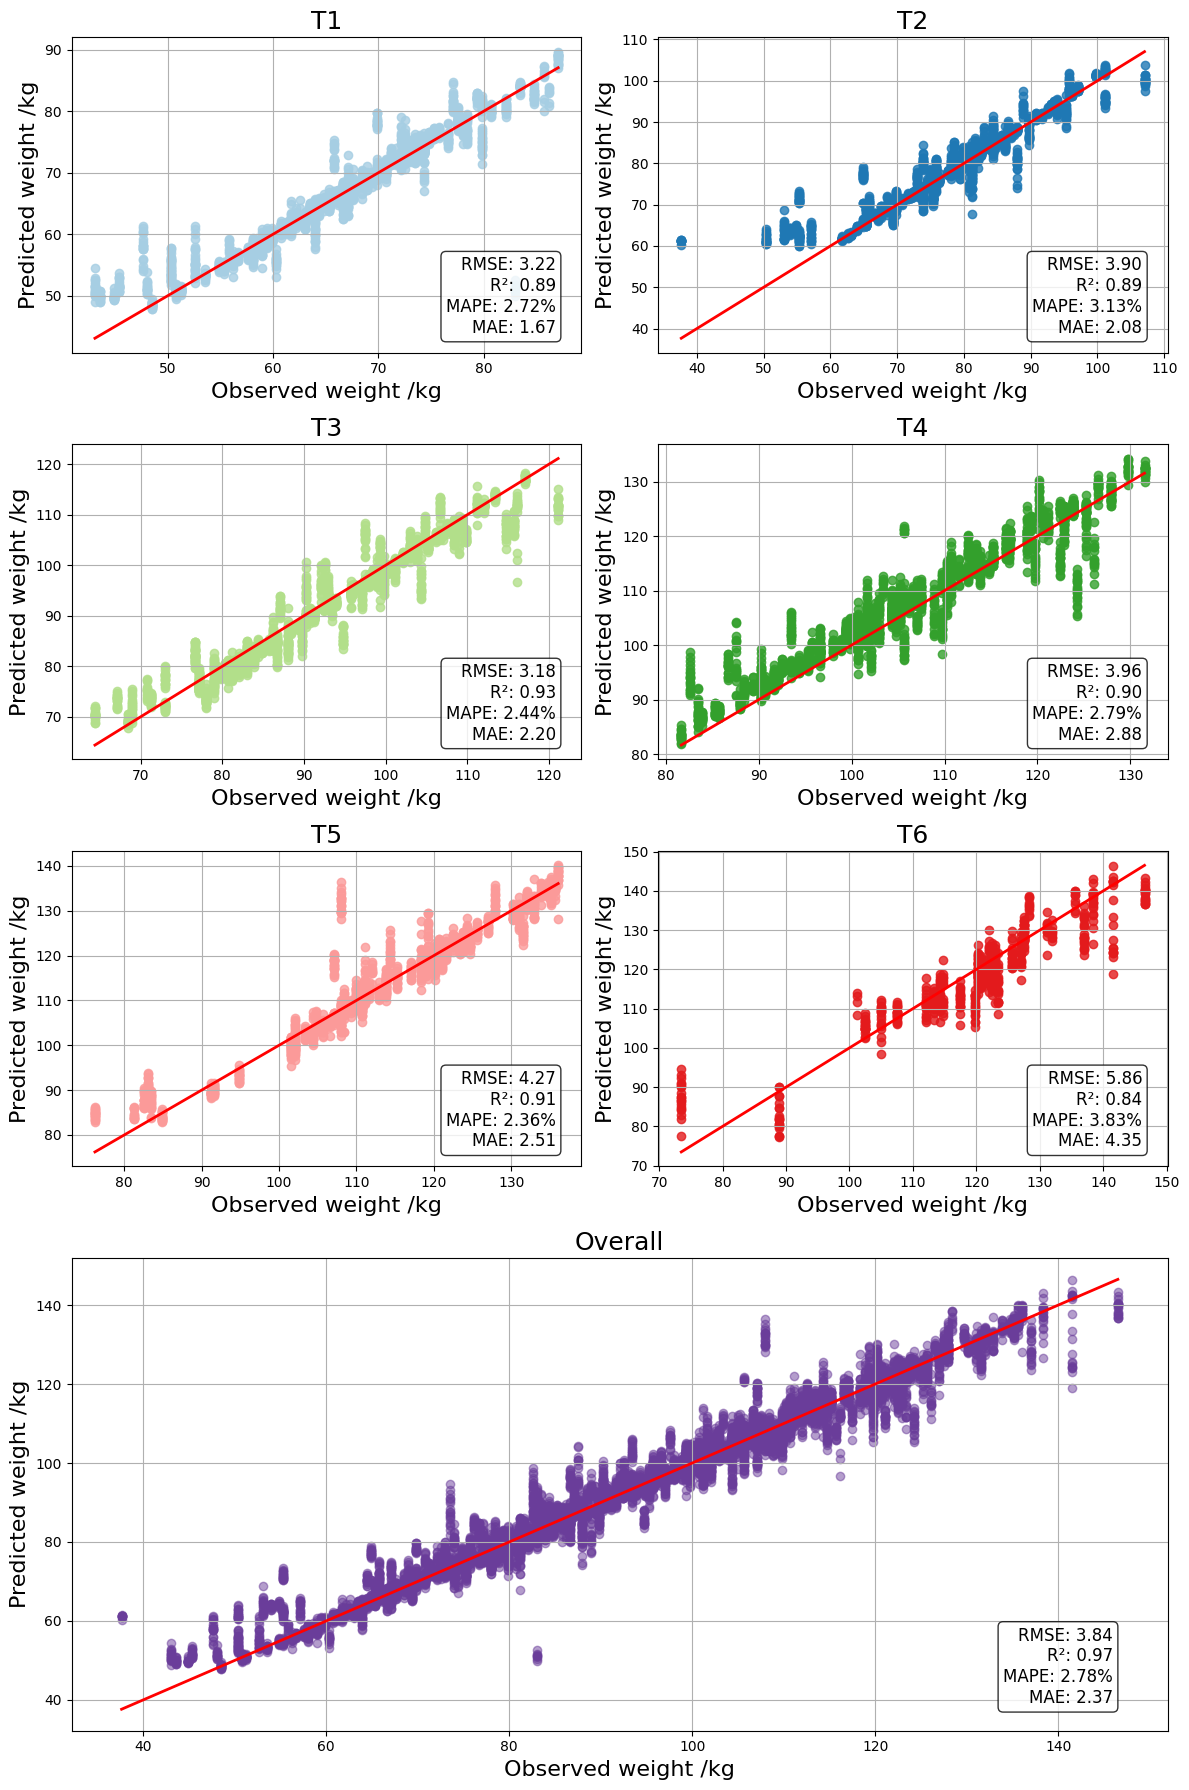

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.gridspec import GridSpec
# List to hold individual dataframes
dataframes = []

for TT in ["T1", "T2", "T3", "T4", "T5", 'T6']:
    file_path = "/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/" + TT + "/weights_comparison.csv"
    # Read the CSV file into a pandas dataframe
    prediction = pd.read_csv(file_path)
    # Add a column to indicate the visit
    prediction["Visit"] = TT
    # Append the dataframe to the list
    dataframes.append(prediction)

# Concatenate all the dataframes in the list into a single dataframe
prediction_df = pd.concat(dataframes, ignore_index=True)



# Define MAPE function
def mape(y_true, y_pred):
    return (abs(y_true - y_pred) / y_true).mean() * 100

# Assuming prediction_df is already created and contains the combined data
# with columns 'predicted_Weights', 'true_Weights', and 'Visit'

# Get the Paired colormap
cmap = plt.get_cmap('Paired')

# Create a figure with subplots
fig = plt.figure(figsize=(12, 18))
gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5])  # Adjust height ratios for better layout

axes = [fig.add_subplot(gs[i]) for i in range(6)]

# List of visits
visits = ["T1", "T2", "T3", "T4", "T5", "T6"]

# Loop through each visit and create a scatter plot
for i, TT in enumerate(visits):
    # Filter the dataframe for the current visit
    df_visit = prediction_df[prediction_df["Visit"] == TT]
    
    y_test = df_visit["true_Weights"]
    predicted_weights = df_visit["predicted_Weights"]
    
    rmse = mean_squared_error(y_test, predicted_weights)**0.5
    r2 = r2_score(y_test, predicted_weights)
    mape_val = mape(y_test, predicted_weights)
    mae = mean_absolute_error(y_test, predicted_weights)

    axes[i].scatter(y_test, predicted_weights, color=cmap(i), alpha=0.8)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Line of perfect prediction

    # Add metrics text to the bottom right
    metrics_text = (f"RMSE: {rmse:.2f}\n"
                    f"R²: {r2:.2f}\n"
                    f"MAPE: {mape_val:.2f}%\n"
                    f"MAE: {mae:.2f}")
    
    axes[i].text(0.95, 0.05, metrics_text, transform=axes[i].transAxes, 
                 fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    axes[i].set_title(f'{TT}', fontsize=18)  # Increase title font size
    axes[i].set_xlabel('Observed weight /kg', fontsize=16)  # Add x-axis label
    axes[i].set_ylabel('Predicted weight /kg', fontsize=16)  # Add y-axis label
    axes[i].grid(True)

# Create the overall plot spanning two columns
ax_overall = fig.add_subplot(gs[3, :])  # Span all columns in the last row

y_test_overall = prediction_df["true_Weights"]
predicted_weights_overall = prediction_df["predicted_Weights"]

rmse_overall = mean_squared_error(y_test_overall, predicted_weights_overall)**0.5
r2_overall = r2_score(y_test_overall, predicted_weights_overall)
mape_val_overall = mape(y_test_overall, predicted_weights_overall)
mae_overall = mean_absolute_error(y_test_overall, predicted_weights_overall)

ax_overall.scatter(y_test_overall, predicted_weights_overall, color=cmap(9), alpha=0.5)
ax_overall.plot([min(y_test_overall), max(y_test_overall)], [min(y_test_overall), max(y_test_overall)], color='red', linewidth=2)  # Line of perfect prediction

# Add metrics text to the bottom right
metrics_text_overall = (f"RMSE: {rmse_overall:.2f}\n"
                        f"R²: {r2_overall:.2f}\n"
                        f"MAPE: {mape_val_overall:.2f}%\n"
                        f"MAE: {mae_overall:.2f}")
    
ax_overall.text(0.95, 0.05, metrics_text_overall, transform=ax_overall.transAxes, 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax_overall.set_title("Overall", fontsize=18)  # Increase title font size
ax_overall.set_xlabel('Observed weight /kg', fontsize=16)  # Add x-axis label
ax_overall.set_ylabel('Predicted weight /kg', fontsize=16)  # Add y-axis label
ax_overall.grid(True)

# Adjust layout to make space for the overall plot
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('/home/yebi/ComputerVision_PLF/Pig_BW/Pig_BW_DL_beta/DL/DrawingPlots/prediction_cv1_scatter_plot.pdf', format='pdf')

# Show the plot
plt.show()


## Draw out the subgroup prediction results in cv1.

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each visit
visits = ["T1", "T2", "T3", "T4", "T5", "T6"]

# Data for each visit
data = {
    "T1": {
        "Weight Interval (kg)": ["40-50", "50-60", "60-70", "70-80", "80-90"],
        "Images in Training": [296, 2136, 2752, 2159, 671],
        "Images in Testing": [129, 445, 810, 597, 124],
        "MAPE (%)": [12.65, 2.11, 1.90, 1.85, 4.14]
    },
    "T2": {
        "Weight Interval (kg)": ["50-60", "60-70", "70-80", "80-90", "90-100", "100-110"],
        "Images in Training": [275, 1436, 3186, 2799, 1393, 154],
        "Images in Testing": [149, 435, 705, 690, 280, 60],
        "MAPE (%)": [18.07, 2.36, 1.62, 1.74, 1.22, 4.53]
    },
    "T3": {
        "Weight Interval (kg)": ["60-70", "70-80", "80-90", "90-100", "100-110", "110-120", "120-130"],
        "Images in Training": [300, 1031, 2337, 3094, 1593, 739, 80],
        "Images in Testing": [78, 289, 616, 691, 500, 140, 20],
        "MAPE (%)": [6.14, 3.58, 2.21, 2.12, 1.56, 2.96, 7.79]
    },
    "T4": {
        "Weight Interval (kg)": ["80-90", "90-100", "100-110", "110-120", "120-130", "130-140"],
        "Images in Training": [884, 2123, 2354, 2112, 999, 180],
        "Images in Testing": [229, 440, 738, 453, 375, 20],
        "MAPE (%)": [5.48, 2.98, 2.51, 1.93, 2.67, 0.60]
    },
    "T5": {
        "Weight Interval (kg)": ["70-80", "80-90", "90-100", "100-110", "110-120", "120-130", "130-140"],
        "Images in Training": [80, 167, 377, 1033, 1580, 1384, 610],
        "Images in Testing": [20, 93, 60, 377, 309, 300, 220],
        "MAPE (%)": [11.08, 5.23, 1.70, 3.12, 1.92, 1.21, 1.41]
    },
    "T6": {
        "Weight Interval (kg)": ["70-80", "80-90", "100-110", "110-120", "120-130", "130-140", "140-150"],
        "Images in Training": [80, 14, 148, 495, 712, 682, 276],
        "Images in Testing": [20, 20, 64, 114, 281, 72, 40],
        "MAPE (%)": [18.88, 7.22, 3.20, 3.57, 2.69, 3.01, 5.81]
    }
}


In [143]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data for each visit
# visits = ["T1", "T2", "T3", "T4", "T5", "T6"]
# data = {
#     "T1": {
#         "Weight Interval (kg)": ["50-60", "60-70", "70-80", "80-90"],
#         "Images in Training": [1913, 2894, 2206, 703],
#         "Images in Testing": [668, 668, 550, 92],
#         "MAPE (%)": [6.23, 3.17, 4.29, 7.50]
#     },
#     "T2": {
#         "Weight Interval (kg)": ["50-60", "60-70", "70-80", "80-90", "90-100", "100-110"],
#         "Images in Training": [88, 1436, 3064, 2831, 1402, 176],
#         "Images in Testing": [20, 435, 827, 658, 271, 38],
#         "MAPE (%)": [17.64, 5.40, 3.44, 2.93, 2.94, 7.31]
#     },
#     "T3": {
#         "Weight Interval (kg)": ["70-80", "80-90", "90-100", "100-110", "110-120", "120-130"],
#         "Images in Training": [1056, 2393, 3040, 1562, 786, 20],
#         "Images in Testing": [264, 560, 745, 531, 93, 80],
#         "MAPE (%)": [3.25, 2.69, 3.03, 2.80, 3.99, 6.57]
#     },

#     "T4": {
#         "Weight Interval (kg)": ["80-90", "90-100", "100-110", "110-120", "120-130", "130-140"],
#         "Images in Training": [884, 2123, 2354, 2112, 999, 180],
#         "Images in Testing": [229, 440, 738, 453, 375, 20],
#         "MAPE (%)": [5.48, 2.98, 2.51, 1.93, 2.67, 0.60]
#     }, 

#     "T5": {
#         "Weight Interval (kg)": ["80-90", "90-100", "100-110", "110-120", "120-130", "130-140"],
#         "Images in Training": [87, 377, 1125, 1527, 1348, 623],
#         "Images in Testing": [60, 60, 285, 362, 336, 207],
#         "MAPE (%)": [7.39, 5.01, 3.94, 2.79, 3.06, 2.80]
#     },
#     "T6": {
#         "Weight Interval (kg)": ["90-100", "100-110", "110-120", "120-130", "130-140", "140-150", "150-160"],
#         "Images in Training": [75, 174, 489, 787, 614, 196, 52],
#         "Images in Testing": [20, 38, 120, 206, 140, 120, 40],
#         "MAPE (%)": [4.11, 2.86, 3.28, 3.16, 2.92, 3.07, 1.17]
#     }
# }


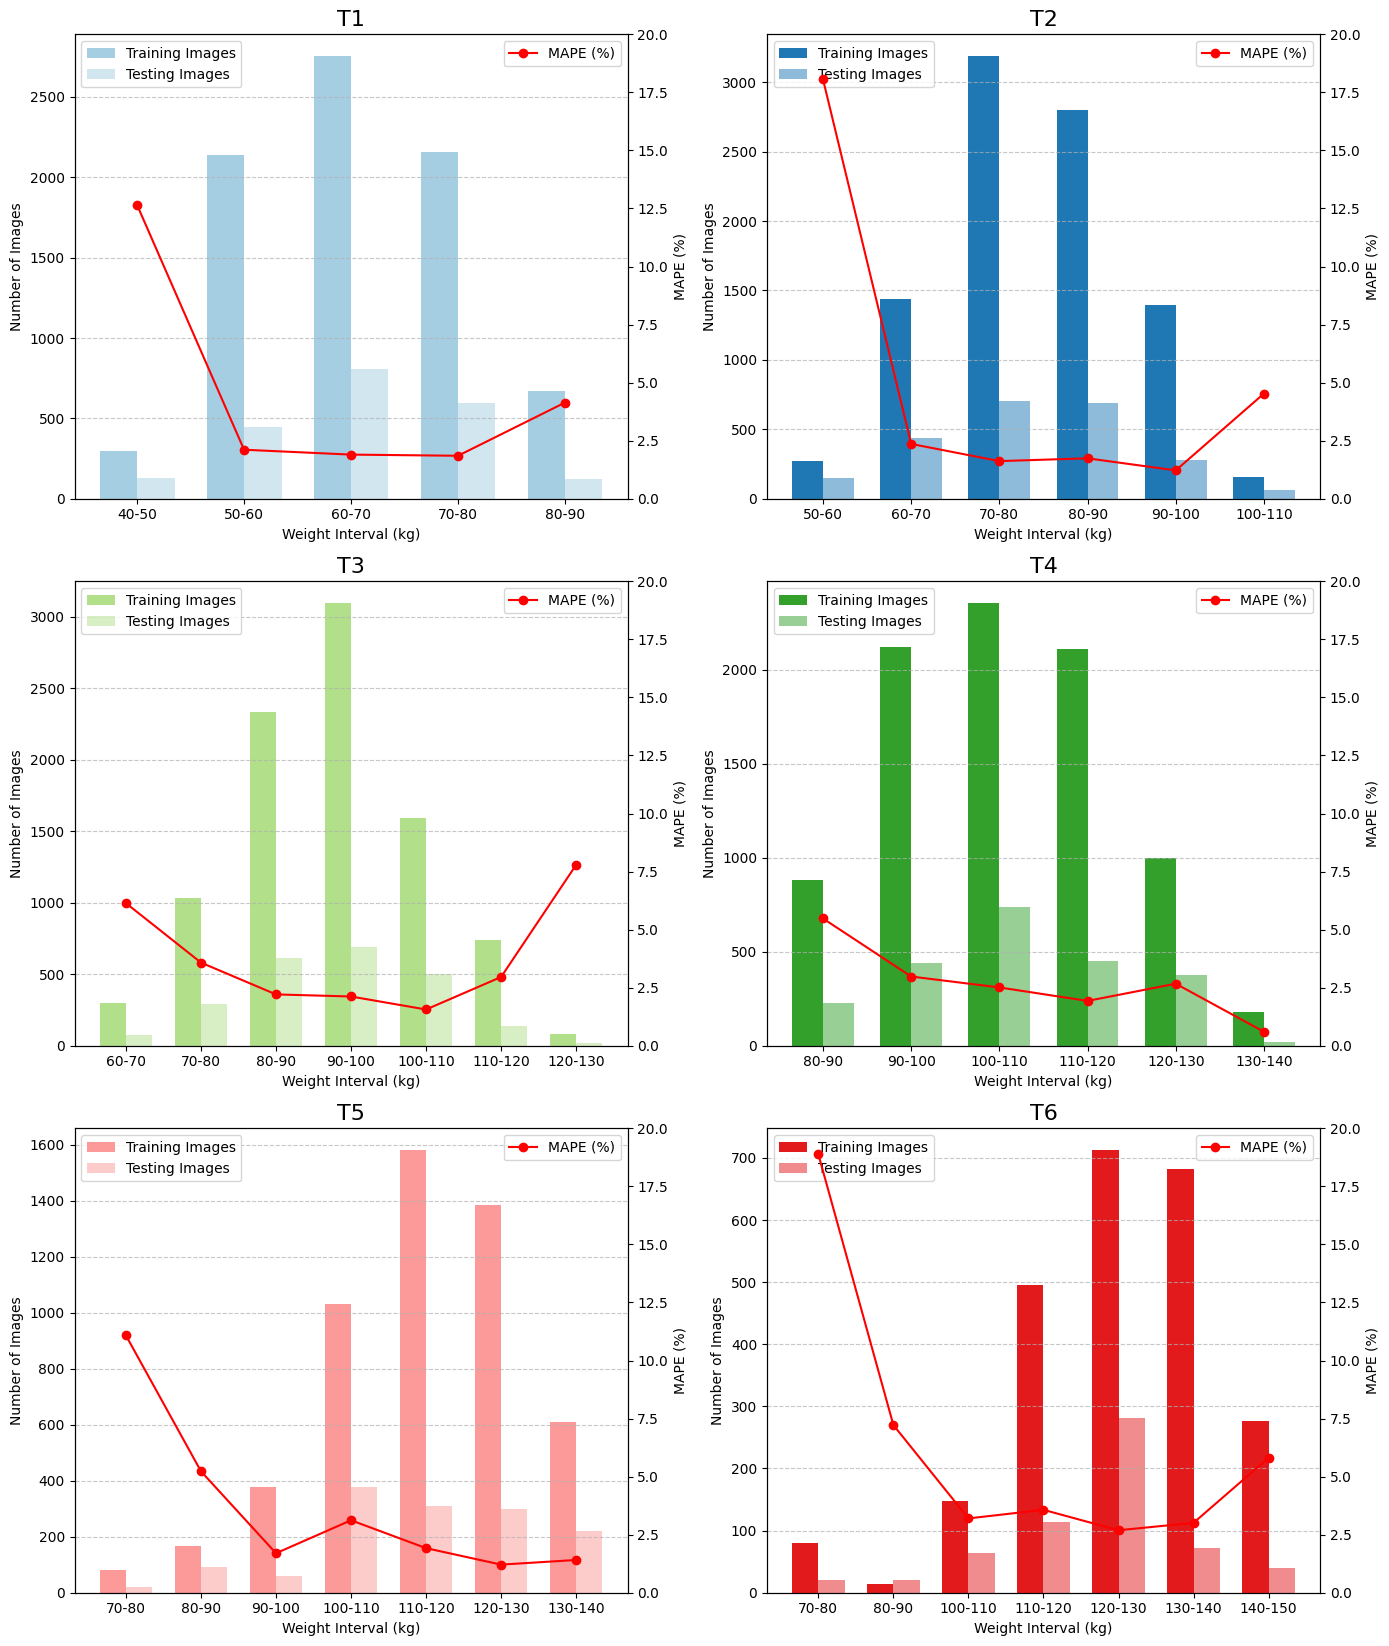

In [312]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust space between subplots

# Get the colormap
cmap = plt.get_cmap('Paired')

# Function to plot for each visit
def plot_for_visit(ax, visit, data, cmap, index):
    weight_intervals = data[visit]["Weight Interval (kg)"]
    images_training = data[visit]["Images in Training"]
    images_testing = data[visit]["Images in Testing"]
    mape = data[visit]["MAPE (%)"]

    # Bar plot for Images in Training and Testing
    bar_width = 0.35
    x = np.arange(len(weight_intervals))

    # Use colormap for bar colors (darker color for training and lighter for testing)
    color_train = cmap(index)
    color_test = cmap(index)
    
    ax.bar(x - bar_width/2, images_training, bar_width, label='Training Images', color=color_train, alpha=1)
    ax.bar(x + bar_width/2, images_testing, bar_width, label='Testing Images', color=color_test, alpha=0.5)

    ax.set_xlabel('Weight Interval (kg)')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'{visit}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(weight_intervals)
    ax.legend(loc='upper left')
    

    # Line plot for MAPE
    ax2 = ax.twinx()
    ax2.plot(x, mape, label='MAPE (%)', color="red", marker='o')
    ax2.set_ylabel('MAPE (%)')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, 20)

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax2.yaxis.grid(False)

# Plot each visit in its subplot
for i, visit in enumerate(visits):
    row, col = divmod(i, 2)
    plot_for_visit(axs[row, col], visit, data, cmap, i)

# Add a super title for the entire figure
# plt.suptitle('Image Counts and MAPE by Visit', fontsize=18)

# Adjust layout to fit the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./DrawingPlots/subgroup_cv1.pdf", format='pdf')
plt.show()

## Drawing image count per visit per pig.

### not good, i used r to redraw this.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from matplotlib.backends.backend_pdf import PdfPages

bag_id_counts=20
# Load the CSV files into DataFrames
df1 = pd.read_csv("./labelled_depth_0718.csv")
df2 = pd.read_csv("./labelled_depth_0801.csv")
df3 = pd.read_csv("./labelled_depth_0815.csv")
df4 = pd.read_csv("./labelled_depth_0829.csv")
df5 = pd.read_csv("./labelled_depth_0912.csv")
df6 = pd.read_csv("./labelled_depth_0927.csv")

# List of DataFrames and corresponding titles
dfs = [df1, df2, df3, df4, df5, df6]
titles = ["T1", "T2", "T3", "T4", "T5", "T6"]

# Define the number of columns for the subplots
n_cols = 2
n_rows = (len(dfs) + n_cols - 1) // n_cols

# Set the figure size (e.g., 18 inches wide and 10 inches high)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 10))
axes = axes.flatten()

# Plot bar plots for the number of images per Bag_ID in each DataFrame
for idx, (df, title) in enumerate(zip(dfs, titles)):
    ax = axes[idx]
    if 'Bag_ID' in df.columns:
        weight_percentile = 1  # Adjust the percentile to remove the lowest 1%
        weight_threshold = df["Weights"].quantile(weight_percentile / 100)
        df = df[df["Weights"] >= weight_threshold]

        # Count the number of images per Bag_ID
        bag_id_counts = df['Bag_ID'].value_counts()
        # thr = 20
        # nnthr = sum(bag_id_counts > thr)
        # nn = df["Bag_ID"].nunique()
        # ratio = round(nnthr / nn, 3)
        # print(f"In {title}, among {nn} Bag_IDs, there are {nnthr} Bag_IDs with counts greater than {thr}, with ratio {ratio}")

        # Plot the bar plot
        bag_id_counts.plot(kind='bar', ax=ax)

        # Draw a horizontal line at y=20 in red color
        ax.axhline(y=20, color='red', linestyle='--')

        # Remove x-axis ticks
        ax.set_xticks([])

        # Set titles and labels
        ax.set_title("\n".join(textwrap.wrap(title, width=30)))
        ax.set_xlabel('Pig ID')
        ax.set_ylabel('Number of image')

        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hide any unused subplots
for ax in axes[len(dfs):]:
    ax.set_visible(False)

plt.tight_layout()

# Save the figure as a PDF
pdf_filename = "image_count.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig(fig, bbox_inches='tight')  # Use bbox_inches to fit the layout

plt.show()
